In [1]:
import numpy
import numpy as np
from abcsysbio import abcsmc
from abcsysbio import input_output
from abcsysbio import kernels
from abcsysbio import abcModel
from abcsysbio import EpsilonSchedule
from abcsysbio import euclidian

from abcsysbio.KernelType import KernelType
from abcsysbio.PriorType import PriorType
from abcsysbio.Prior import Prior

import matplotlib
%matplotlib inline
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import re

%load_ext autoreload
%autoreload 2
matplotlib.rcParams['savefig.dpi'] = 3 * matplotlib.rcParams['savefig.dpi']

In [2]:
pickling = True
plot = True
plotTimeSeries = True
debug = 1#or 0 or 2 (higher the more details)
randomSeed = None #or an integer
timing = False
fname = "results_"  # outfolder
custom_kernel = False
restart = False
mode = 0

if randomSeed is not None:
    print "#### Seeding random number generator : ", randomSeed
    numpy.random.seed(randomSeed)

modelKernel = 0.7
nparticles = 200

kernel = KernelType.component_wise_uniform  #check out kernalType.py

nbatch = 10

# Defining models

5.0


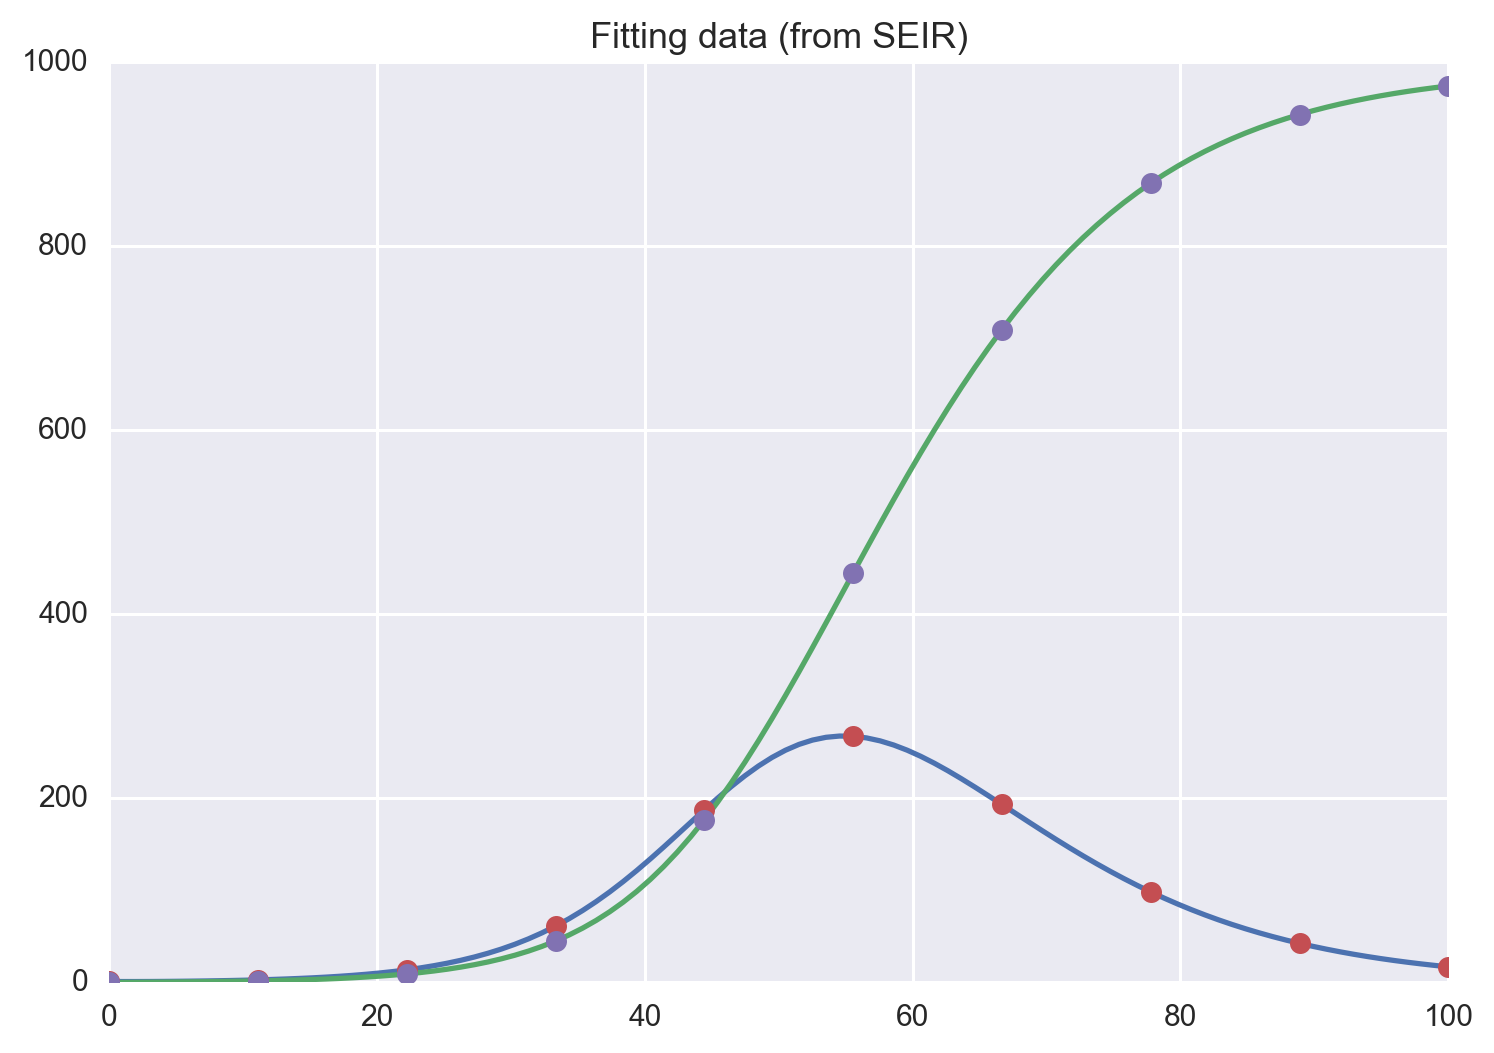

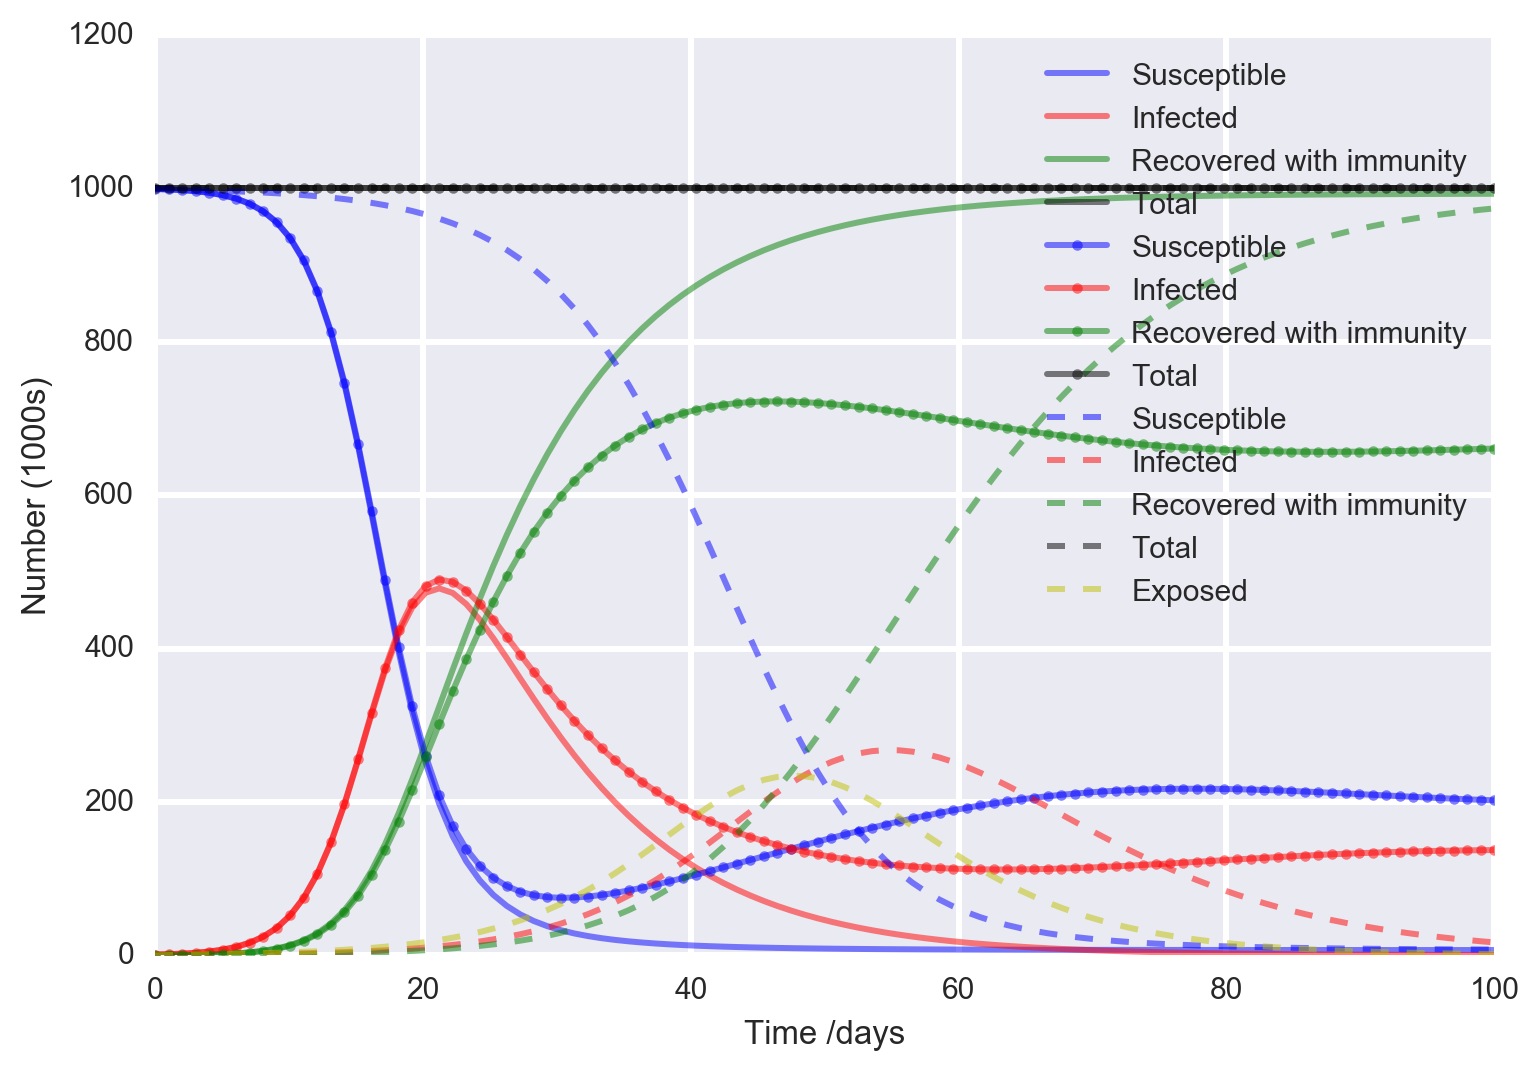

In [3]:
def doAPlot(fig, t,toPlots,labels,line='-'):

    ax = fig.add_subplot(111)#, axis_bgcolor='#dddddd', axisbelow=True)
    colors = ['b','r','g','k','y']
    for i,toPlot in enumerate(toPlots):
        ax.plot(t, toPlot, colors[i] + line, alpha=0.5, lw=2, label=labels[i])
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
E0 = 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
#Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
#1/gamma: average infectious period
#beta, gamma = 0.2, 1./10.0
#beta, gamma = 0.7, 1./10.0

betaI, gammaI, epsI, f = 2.0, 10.0, 7.0, 1.0/50.0

#Birth rate, and death rate
B, mu = 5, 0.005
B, mu = 0, 0

#1/eps is average latent period
#eps = 1/7.0

#how quickly do you fall back to being susiptible again.
#f = 1/50.0

# A grid of time points (in days)
finalT = 100.0
t  = np.linspace(0, finalT, 100)
t2 = np.linspace(0, finalT, 10)

# SIR, no latent period, but with reocevered becoming suspitible again
def deriv_SIR(y, t, N, betaI, gammaI, B, mu,f):

    '''GOD HORRIBLE HACK, BUT I LIKE DAYS RATHER THAN 1/DAYS'''
    beta = 1/betaI
    gamma = 1/gammaI
    #f = 1/fI

    #print betaI, gammaI, fI

    S, I, R = y
    Nt = S + I + R
    dSdt = B-beta * S * I / Nt - mu * S + f * R
    dIdt = beta * S * I / Nt - gamma * I - mu * I
    dRdt = gamma * I - mu * R - f * R
    return dSdt, dIdt, dRdt

# SIR, no latent period, recovered are always recovered
def deriv_SIR_basic(y, t, N, beta, gamma, B, mu):
    return deriv_SIR(y, t, N, beta, gamma, B, mu, 0)

#SIR, with latent period, and susiptible becoming potentially ill again.
def deriv_SEIR(y, t, N, betaI, gammaI, B, mu, f, epsI):
    S, E, I, R = y
    Nt = S + E + I + R

    beta  = 1/betaI
    gamma = 1/gammaI
    #f     = 1/fI
    eps  = 1 / epsI

    dSdt = B-beta * S * I / Nt - mu * S + f * R
    dEdt = beta * S * I / Nt - (eps + mu) * E
    dIdt = eps * E - (gamma + mu) * I
    dRdt = gamma * I - mu * R - f * R
    return dSdt, dEdt, dIdt, dRdt

print (1/betaI)/(1/gammaI)

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret_basic = scipy.integrate.odeint(deriv_SIR_basic, y0, t, args=(N, betaI, gammaI, B, mu))
ret_SIR = scipy.integrate.odeint(deriv_SIR, y0, t, args=(N, betaI, gammaI, B, mu, f))


y0 = S0, E0, I0, R0
ret_SEIR  = scipy.integrate.odeint(deriv_SEIR, y0, t, args=(N, betaI, gammaI, B, mu, 0, epsI))
ret_SEIR2 = scipy.integrate.odeint(deriv_SEIR, y0, t2, args=(N, betaI, gammaI, B, mu, 0, epsI))

fig2 = plt.figure()#(facecolor='w')
plt.hold(True)
plt.title('Fitting data (from SEIR)')
S, E, I, R = ret_SEIR.T
S2, E2, I2, R2 = ret_SEIR2.T
plt.plot(t,I)
plt.plot(t,R)
plt.plot(t2,I2,'o')
plt.plot(t2,R2,'o')


S, I, R = ret_basic.T
fig1 = plt.figure(facecolor='w')
doAPlot(fig1,t,[S,I,R,S+I+R],['Susceptible','Infected','Recovered with immunity','Total'])
S, I, R = ret_SIR.T
#S2, I2, R2 = ret2.T
doAPlot(fig1,t,[S,I,R,S+I+R],['Susceptible','Infected','Recovered with immunity','Total'],line='.-')
#doAPlot(fig2,t,[S2,I2,R2,S2+I2+R2],['Susceptible','Infected','Recovered with immunity','Total'],line='.-')

S, E, I, R = ret_SEIR.T
#fig3 = plt.figure()#(facecolor='w')
doAPlot(fig1,t,[S,I,R,S+E+I+R,E],['Susceptible', 'Infected','Recovered with immunity','Total','Exposed'],line='--')


#gamma = 1/recovery period in days
#beta  = contact rate (number of contacts per day)
#B and mu birth and death rate
#eps = 1/Latent Priod
#f   = 1/fallback period

#betaI, gammaI, epsI, fI = 2.0, 10.0, 7.0, 50.0

pDaysBeforeContact = Prior(type=PriorType.uniform,  lower_bound=1.0, upper_bound=10.0)
pRecoveryPeriod    = Prior(type=PriorType.uniform,  lower_bound=1.0, upper_bound=30.0)
pLatentPeriod      = Prior(type=PriorType.uniform,  lower_bound=1.0, upper_bound=10.0)
pFallbackPeriod    = Prior(type=PriorType.uniform,  lower_bound=30.0, upper_bound=200.0)
pFallbackRate      = Prior(type=PriorType.uniform,  lower_bound=0.0, upper_bound=1.0)
pFallbackPeriodConstant    = Prior(type=PriorType.constant,  value=np.Inf)
pFallbackRateConstant    = Prior(type=PriorType.constant,  value=0)
pBirth             = Prior(type=PriorType.constant, value=0.0)
pDeath             = Prior(type=PriorType.constant, value=0.0)
pPopulation        = Prior(type=PriorType.constant, value=1000.0)

def dist_metric(d, x, params, model):
    S2, E2, I2, R2 = x
    allPoints = np.concatenate((I2-d[:,-2],R2-d[:,-1]))
    distance = np.sum(allPoints**2)**0.5/len(allPoints)
    #if np.isnan(distance):
    #    print model.name, params
    return [distance]

def simulation_SIR(paramsArray, pool=None):
    y0 = S0, I0, R0
    r = np.empty((len(paramsArray), 1, len(t2), 4))
    for i, x in enumerate(paramsArray):
        r[i, 0, :, :] = scipy.integrate.odeint(deriv_SIR, y0, t2, args=tuple(x))
    return r

def simulation_SIR_basic(paramsArray, pool=None):
    y0 = S0, I0, R0
    r = np.empty((len(paramsArray), 1, len(t2), 3))
    for i, x in enumerate(paramsArray):
        r[i, 0, :, :] = scipy.integrate.odeint(deriv_SIR_basic, y0, t2, args=tuple(x))
    return r

def simulation_SEIR(paramsArray, pool=None):
    y0 = S0, E0, I0, R0
    r = np.empty((len(paramsArray), 1, len(t2), 4))
    for i, x in enumerate(paramsArray):
        r[i, 0, :, :] = scipy.integrate.odeint(deriv_SEIR, y0, t2, args=tuple(x))
    return r

# Performing Inference

In [4]:
priors_SIR       = [pPopulation, pDaysBeforeContact, pRecoveryPeriod, pBirth, pDeath, pFallbackRate]
priors_SIR_basic = [pPopulation, pDaysBeforeContact, pRecoveryPeriod, pBirth, pDeath]
priors_SEIR      = [pPopulation, pDaysBeforeContact, pRecoveryPeriod, pBirth, pDeath, pFallbackRateConstant, pLatentPeriod]

models = []

model_SIR = abcModel.AbcModel(name='SIR',
                           simulationFn=simulation_SIR,
                           distanceFn=dist_metric,
                           nparameters=6,
                           prior=priors_SIR)

model_SIR_basic = abcModel.AbcModel(name='SIR_Basic',
                           simulationFn=simulation_SIR_basic,
                           distanceFn=dist_metric,
                           nparameters=5,
                           prior=priors_SIR_basic)

model_SEIR = abcModel.AbcModel(name='SEIR',
                           simulationFn=simulation_SEIR,
                           distanceFn=dist_metric,
                           nparameters=7,
                           prior=priors_SEIR)



if True:
    models = [model_SIR_basic, model_SEIR]
else:
    models = [model_SEIR]

names  = [x.name for x in models]
nmodels = len(models)
modelprior = [1 / float(nmodels)] * nmodels


# set the required kernel functions
kernelfn = kernels.get_kernel
kernelpdffn = kernels.get_parameter_kernel_pdf
perturbfn = kernels.perturb_particle



parms       = [1000, 2.0, 10.0, 0, 0, 0, 7.0]
parms_basic = [1000, 2.0, 10, 0, 0]
(dist_metric(simulation_SEIR((parms,))[0,0,:,:],ret_SEIR2.T, None, None),
dist_metric(simulation_SIR_basic((parms_basic,))[0,0,:,:],ret_SEIR2.T, None, None))




([0.0], [156.00563357833579])

In [5]:
class Data:
    def __init__(self, times, values):
        self.timepoints = times
        self.values = values


In [7]:
restart = False
fname = 'results_'
niter = 40
firstEpsilon = 50
lastEpsilon  = 9 #rstEpsilon * 0.01

tol_type = 'exp'
epsilonSchedule = EpsilonSchedule.EpsilonSchedule(tol_type, lastEpsilon, firstEpsilon, niter).tol
epsilonSchedule

io = input_output.InputOutput(fname, restart, False, False)
io.create_output_folders(["SIR","SIR_Basic", "SEIR"], pickling, True, False)

abcSmcInstance = abcsmc.Abcsmc(models=models,
                               nparticles=nparticles,
                               modelprior=modelprior,
                               data=Data(t2, ret_SEIR2.T),
                               beta=1,
                               nbatch=nbatch,
                               model_kernel=modelKernel,
                               debug=debug,
                               timing=timing,
                               distancefn=dist_metric,
                               kernel_type=kernel,
                               kernelfn=kernelfn,
                               kernelpdffn=kernelpdffn,
                               perturbfn=perturbfn)


if restart:
    abcSmcInstance.fill_values(io.read_pickled(fname))

allResults = abcSmcInstance.run_fixed_schedule(epsilonSchedule, io, store_all_results=True)

### Found special kernel case 1 for model  0 ###
### Found special kernel case 1 for model  1 ###
### population  1
	 sampling steps / acceptance rate : 729 / 0.274348422497
	 model marginals                  : [0.5200000000000004, 0.4800000000000003]
### population  2
	 sampling steps / acceptance rate : 322 / 0.621118012422
	 model marginals                  : [0.39237684353870805, 0.60762315646129195]
### population  3
	 sampling steps / acceptance rate : 339 / 0.589970501475
	 model marginals                  : [0.51117458952205963, 0.48882541047794037]
### population  4
	 sampling steps / acceptance rate : 322 / 0.621118012422
	 model marginals                  : [0.43742409487548067, 0.56257590512451927]
### population  5
	 sampling steps / acceptance rate : 344 / 0.581395348837
	 model marginals                  : [0.47141063758626311, 0.52858936241373733]
### population  6
	 sampling steps / acceptance rate : 316 / 0.632911392405
	 model marginals                  : [0.41447264

# Plotting

Plotting the model marginals reveals that on successive models, we become more confident that model 1 (SEIR) is the corrct model.

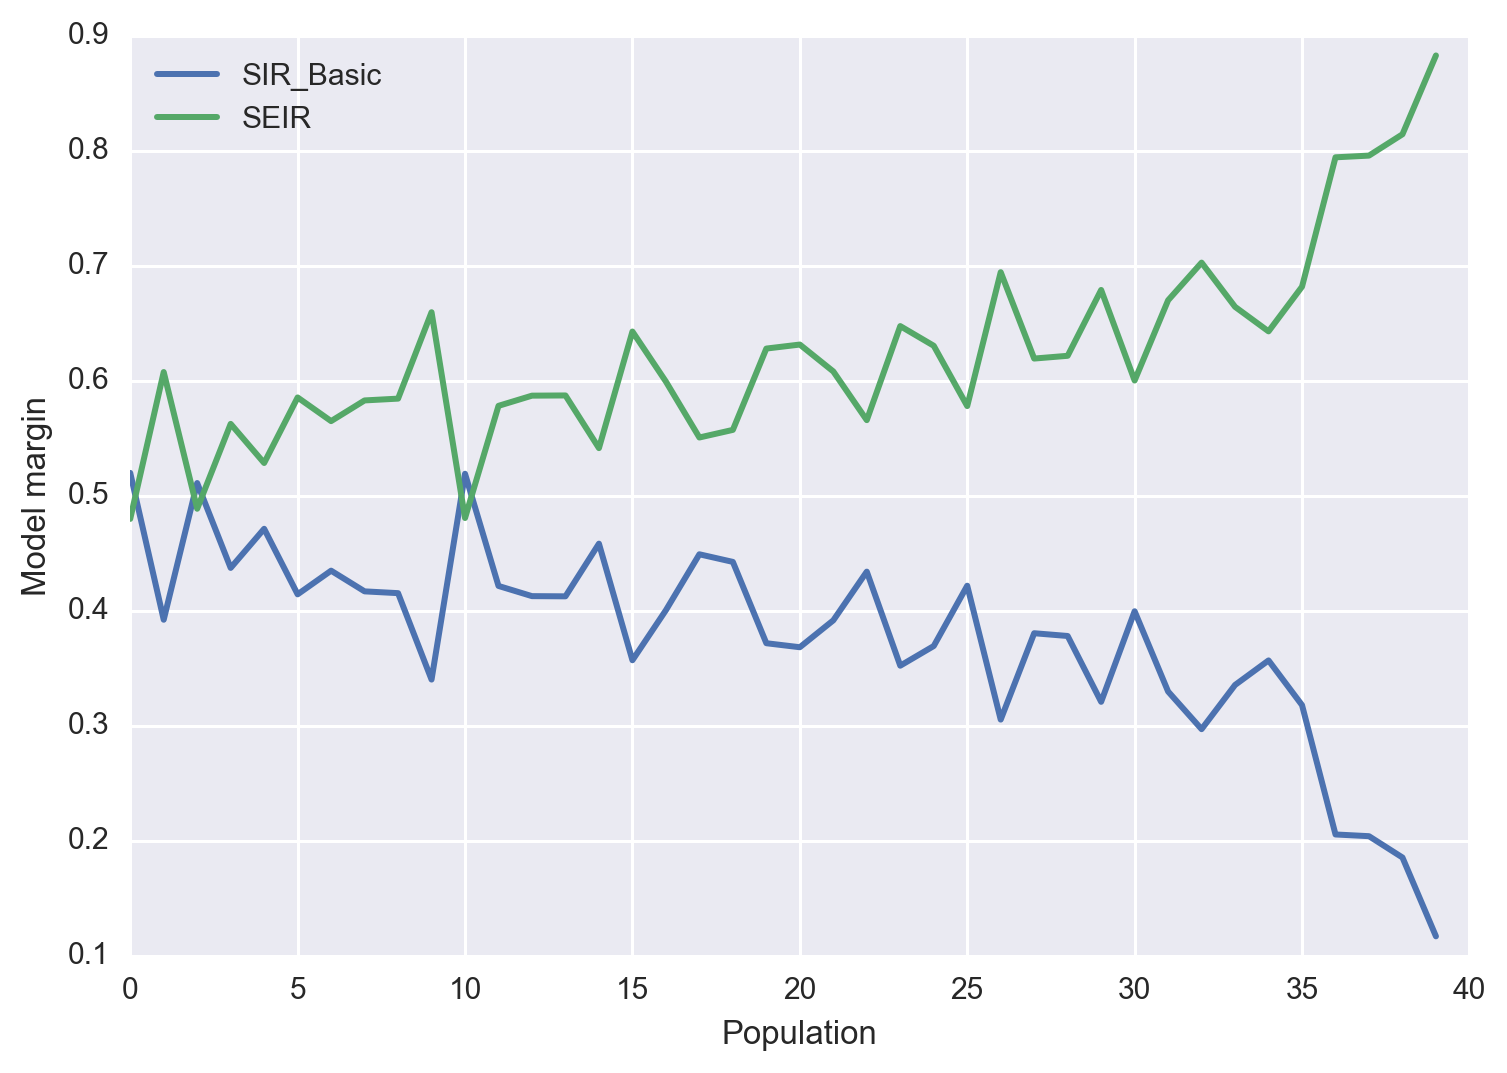

In [8]:
from abcsysbio import plotter
plotter.modelMarginsByPopulation(allResults,models)

Let's plot the estimated posterior of the model 1 (the correct model) in the last population, to get an idea of how much uncertainty we have about the parameters:


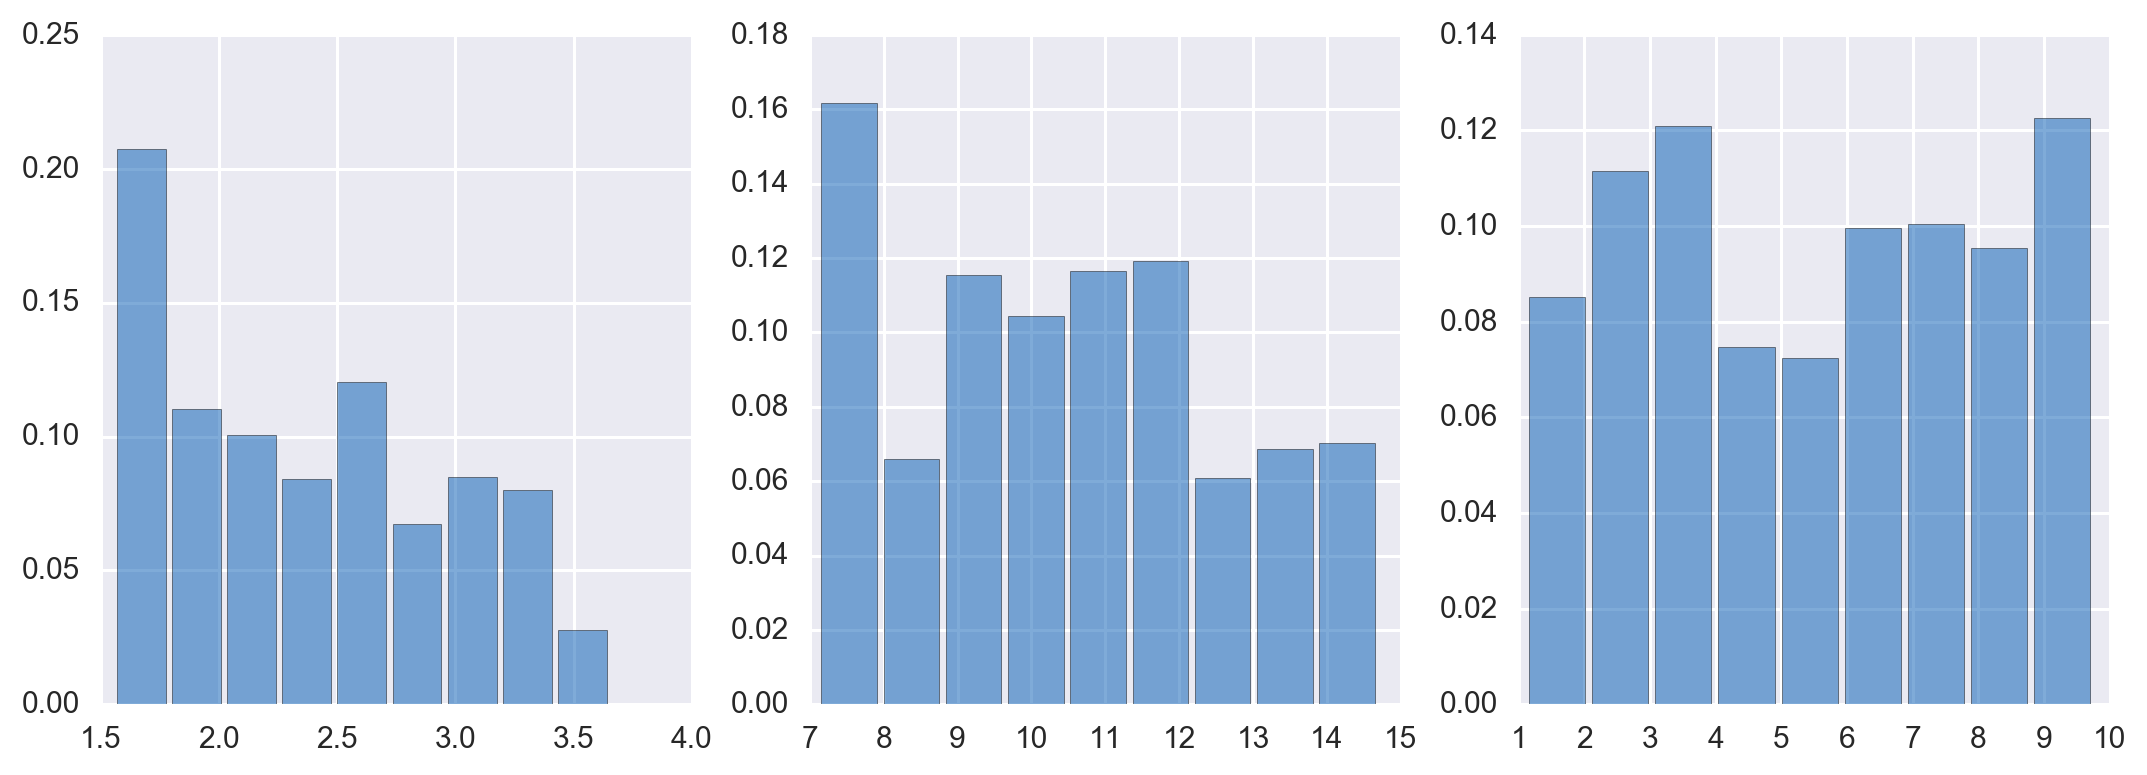

In [9]:
plotter.plotHistogram(allResults[-1], 1, models=models)

Let's examine this more closely with a pairplot for all iterations, indicating the true parameter values with a cross-hair.

This shows how our uncertainty is decreaisng with successive iterations.
The point-cloud isn't *centered* on the true value, but does cover it.

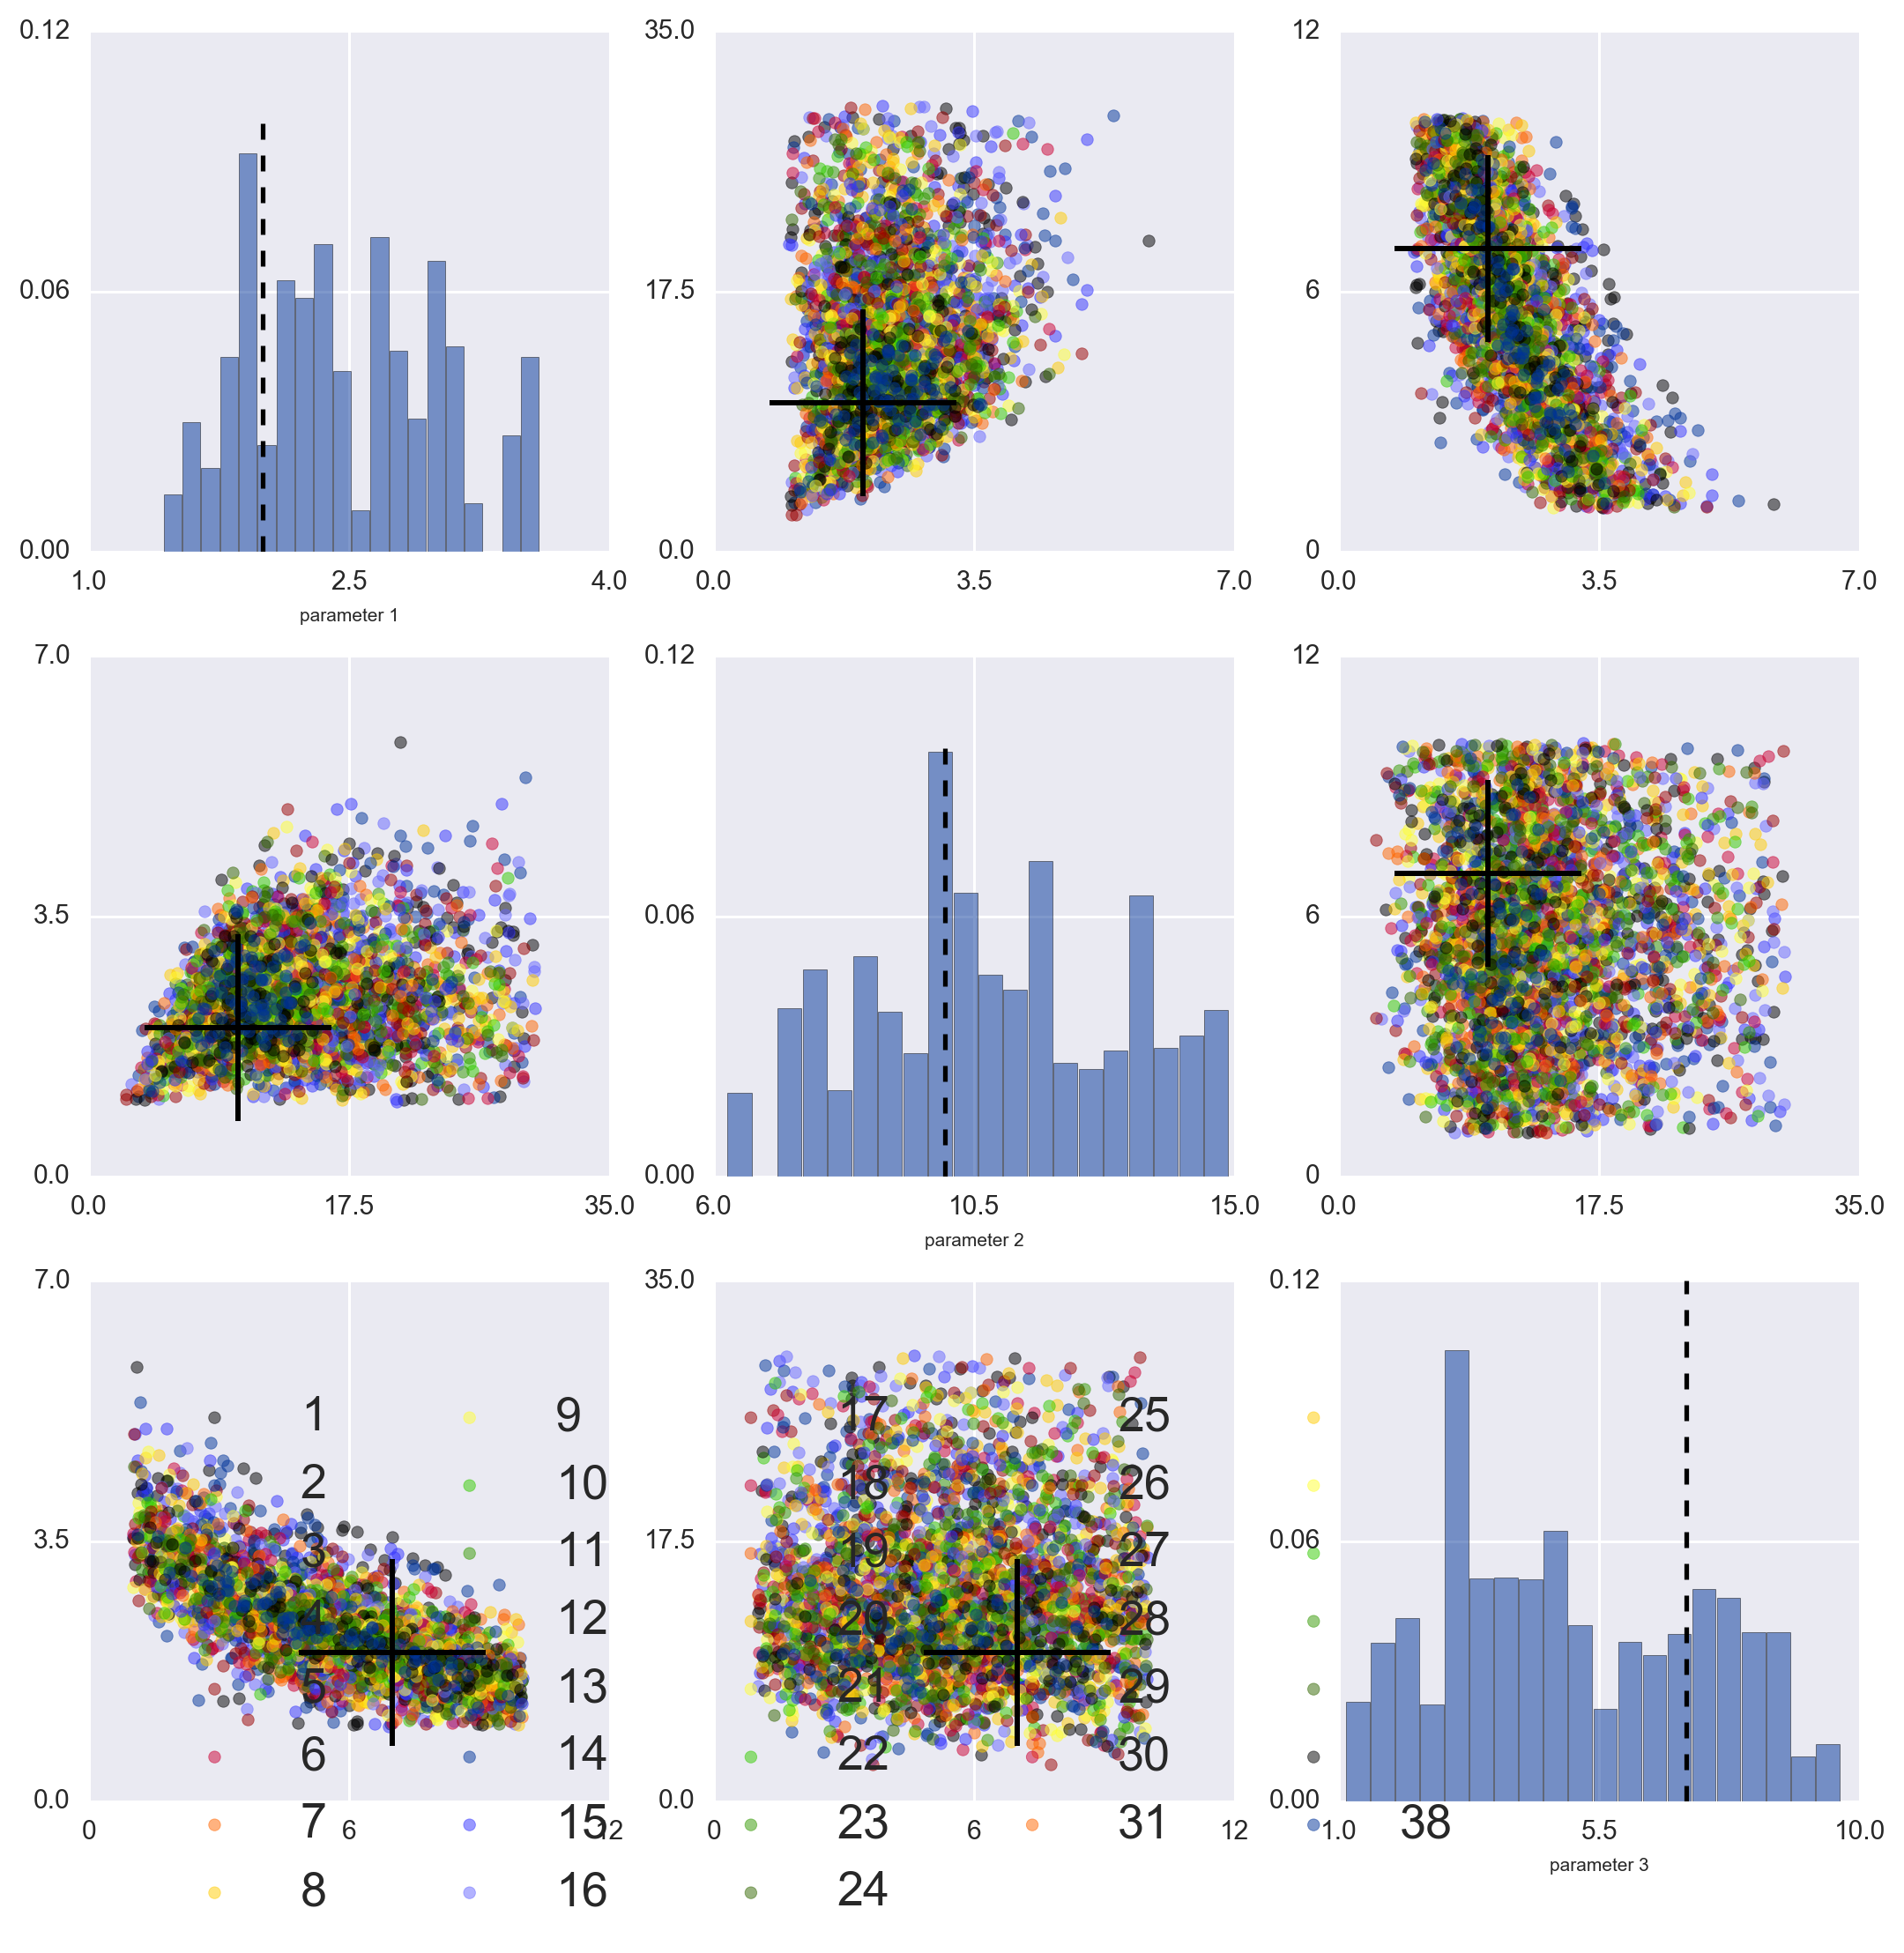

In [10]:
plotter.doPairPlot(allResults, 1,range(1,niter-1), models,actualValues=(2.0,10.0,7.0))

Let's do a pair-plot of the last iteration of the correct model (model 1)

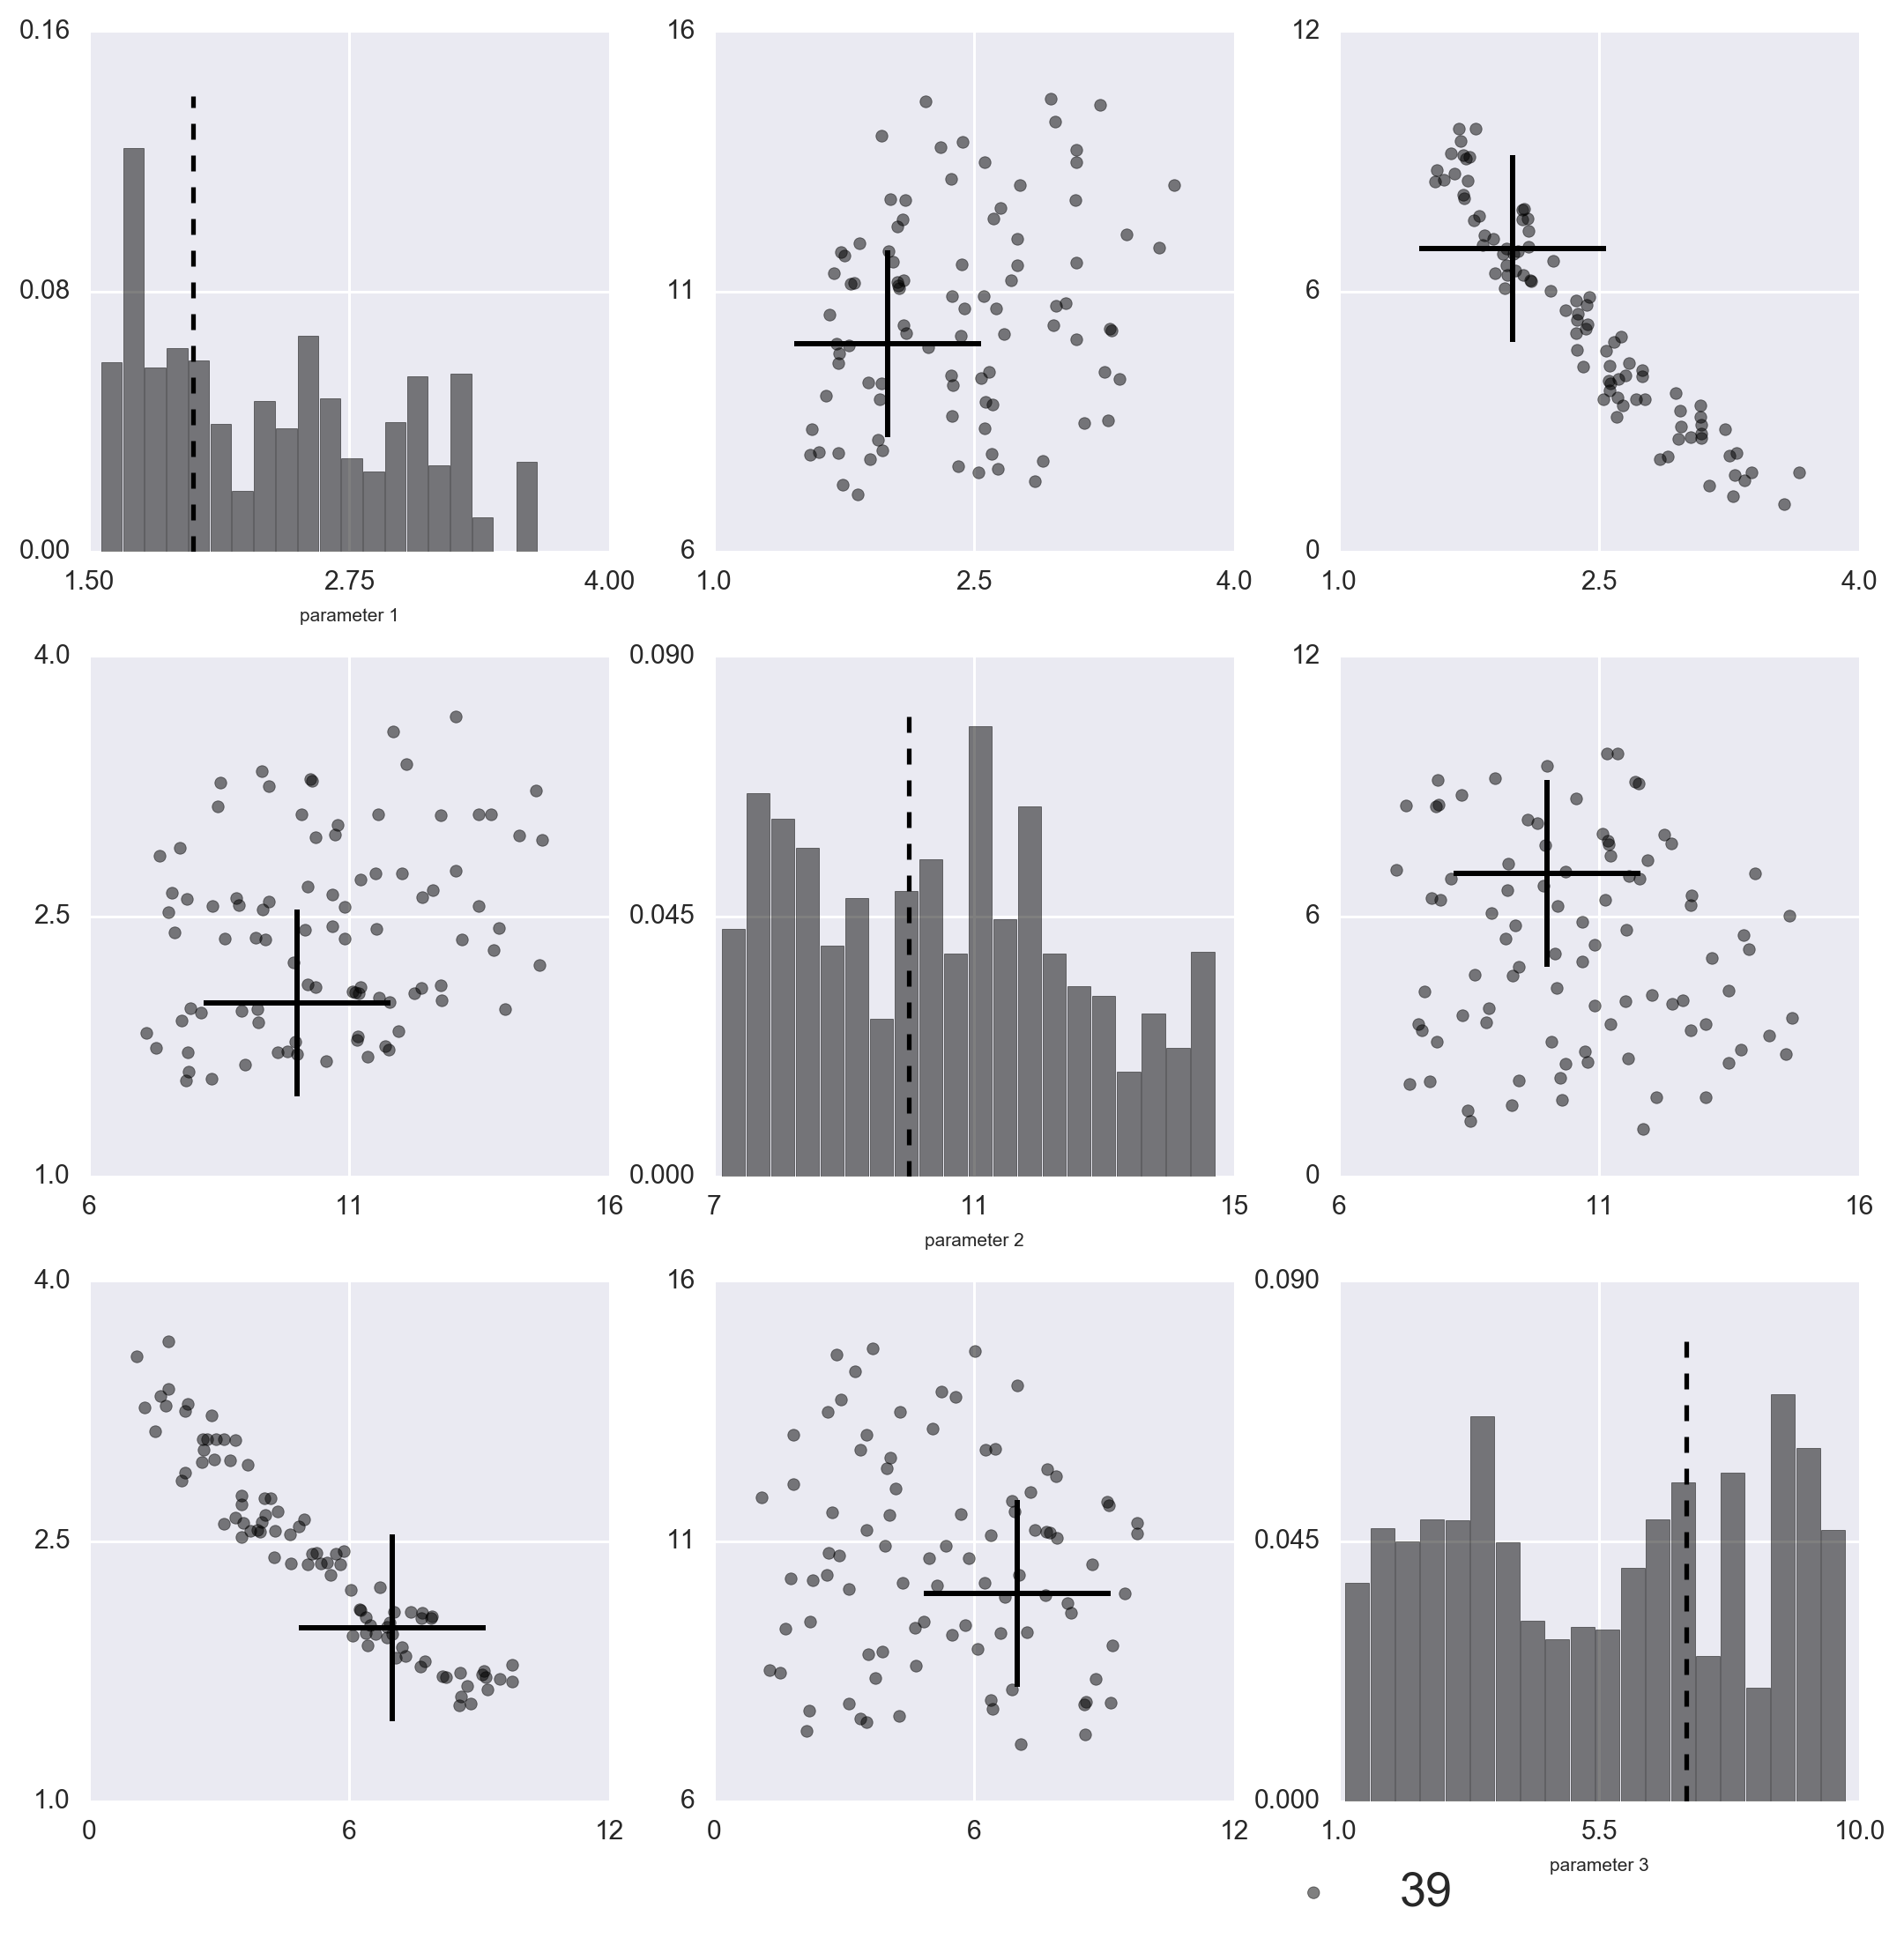

In [11]:
plotter.doPairPlot(allResults, 1, [niter-1], models,actualValues=(2.0,10.0,7.0))

In contrast, for the 'incorrect' model, the true value lies some way away from the point-cloud: trying to estimate parameters by fititng the wrong model gives incorrect results:

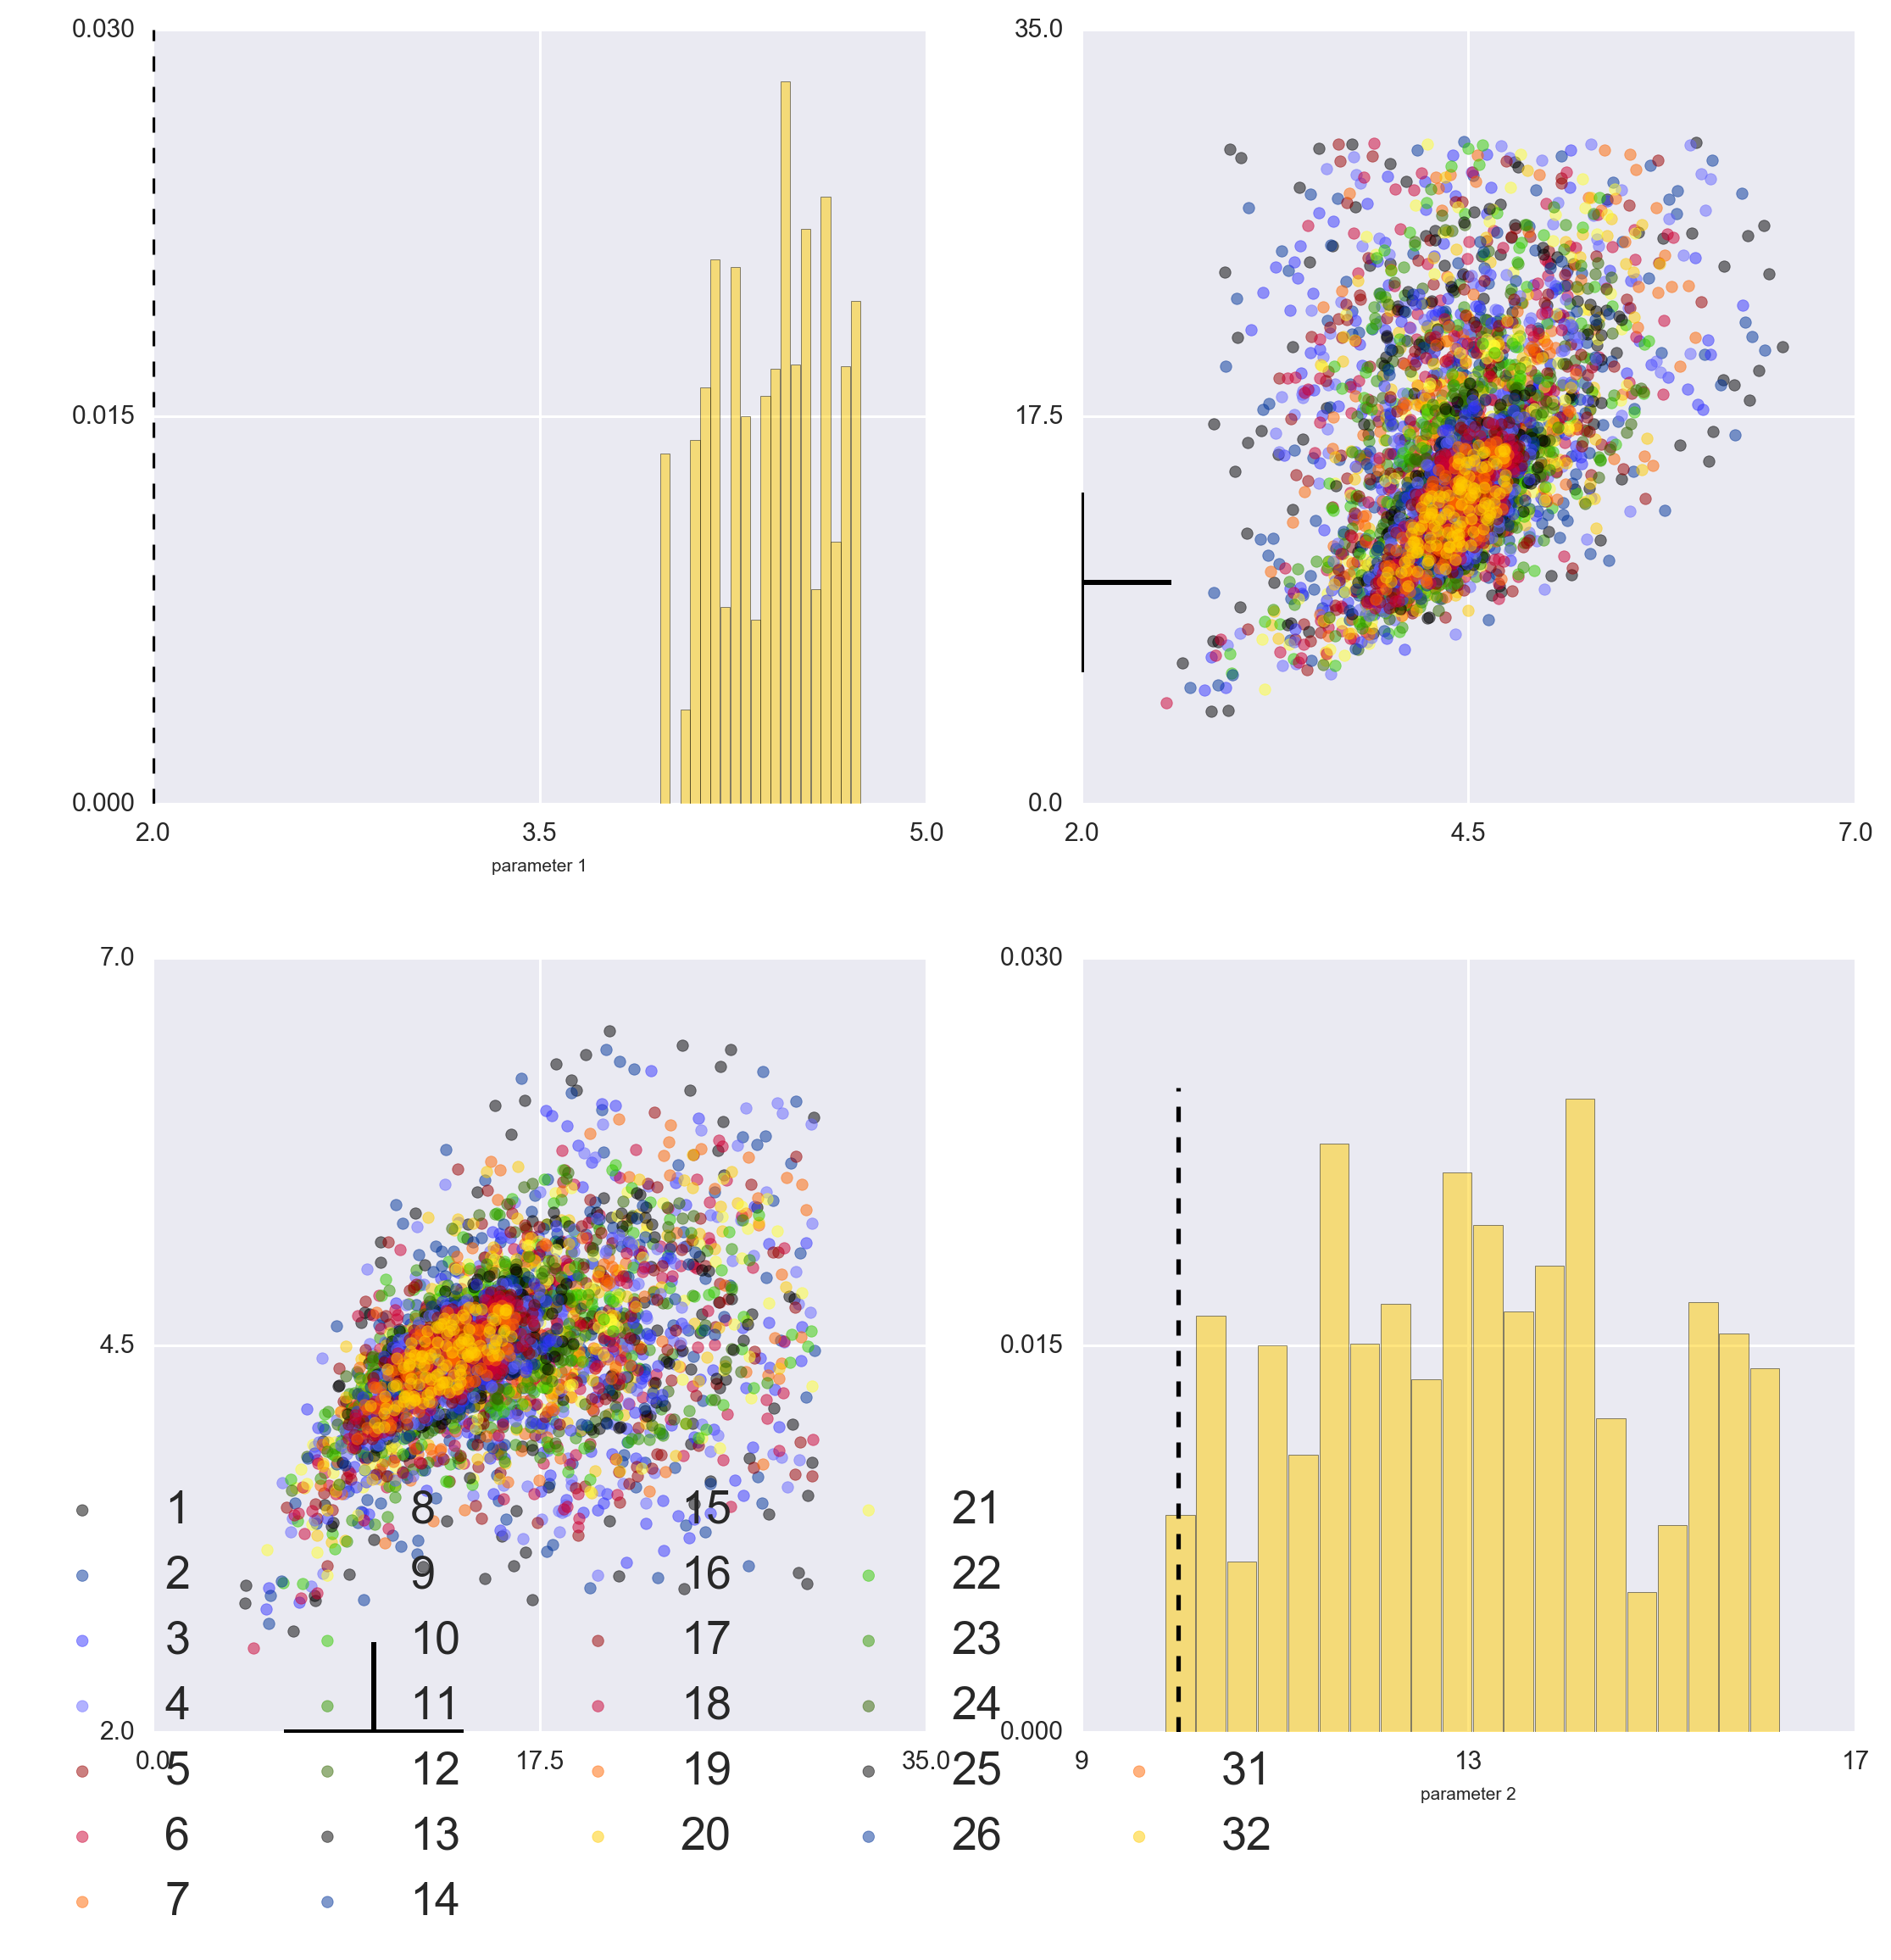

In [12]:
plotter.doPairPlot(allResults, 0, range(1,33), models,actualValues=(2.0,10.0,7.0))